# Defining structures for RCWA calculations

This example will demonstrate how layers are patterned for RCWA calculations using S4. There are four shape types: circle, ellipse, rectangle, and general polygon. When defining shapes, one shape can be completely inside another shape but the shapes CANNOT overlap (even if they are made of the same material, strange things will start to happen such as one shape being ignored, or the overlapping region being defined as having the sum of the dielectric constants).

First, relevant imports:

In [1]:
import numpy as np
from solcore import si, material
from solcore.structure import Layer
from solcore.solar_cell import SolarCell

from rayflare.rigorous_coupled_wave_analysis import rcwa_structure
from rayflare.options import default_options

import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

import warnings
warnings.filterwarnings('ignore')

Create the relevant instances of Solcore materials to use and define some options (wavelengths and number of Fourier orders). We also define the lattice vectors of the unit cell to use for the RCWA calculations, in this case an equilateral triangle:

In [2]:
InAlP_hole_barrier = material('AlInP')(Al=0.5)
GaAs_pn_junction = material('GaAs')()
InGaP_e_barrier = material('GaInP')(In=0.5)
Ag = material('Ag')()
Au = material('Au')()
SiN = material('Si3N4')()
Air = material('Air')()

wavelengths = np.linspace(303, 1000, 50) * 1e-9

x = 500

size = ((x, 0), (x / 2, np.sin(np.pi / 3) * x))

options = default_options()
options.wavelengths = wavelengths
options.orders = 60

We now define a few different grating geometries. The basis for the S4 calculations are Solcore Layer objects, which can optionally have a 'geometry' attribute. This geometry is a list of dictionaries, each of which contains one shape to add to the periodic array. You can add any number of shapes (note that even if you are only added one shape, such as the first four examples below, the geometry should still take the form of a list! The required dictionary entries for each shape can be found [here](http://docs.solcore.solar/en/master/Optics/S4doc.html). Note that all dimensional information for these shapes is in nm, rather than m which is standard for most of RayFlare.

The angle of a shape is in degrees counterclockwise from the x-axis. The halfwidths for rectangles and ellipses are in the x and y direction, respectively, for an unrotated shape. For the polygon, the vertices are always relative to the centre, even when the centre is not at (0, 0) (see the fifth example). The final list entry is no geometry, so the simulation will assume a planar layer of SiN.

In [3]:
grating_circles =[{'type': 'circle', 'mat': Ag, 'center': (0, 0), 'radius': 115}]

grating_squares = [{'type': 'rectangle', 'mat': Ag, 'center': (0, 0),
                    'halfwidths': [115, 115], 'angle': 20}]

grating_ellipse = [{'type': 'ellipse', 'mat': Ag, 'center': (0, 0),
                    'halfwidths': [150, 110], 'angle': 20}]

grating_polygon = [{'type': 'polygon', 'mat': Ag, 'center': (0, 0), 'angle': 0,
                   'vertices': ((150, 0), (0, 150), (-150, 0))}]

grating_circle_polygon = [{'type': 'circle', 'mat': Ag, 'center': (0, 0), 'radius': 115},
                         {'type': 'polygon', 'mat': Au, 'center': (200, 150), 'angle': -20,
                   'vertices': ((150, 0), (0, 150), (-150, 0))}]

grating_list = [grating_circles, grating_squares, grating_ellipse,
                grating_polygon, grating_circle_polygon, None]

Now we are going to loop through all the different grating options, putting them under a thin GaAs solar cell-type structure. The final layer is the grating, which is made of SiN, with the shapes defined above passed to the 'geometry' argument of Layer one by one inside the loop. We keep track of the absorption in the GaAs layer and in the grating layer, and plot the dielectric constants for each grating type (the real part is plotted on the left and the imaginary part on the right). Note that these plots look 'fuzzy' because this is plotting the actual Fourier-transformed epsilon as it is used in the RCWA calculations, so more orders will make things less fuzzy and fewer orders more fuzzy.

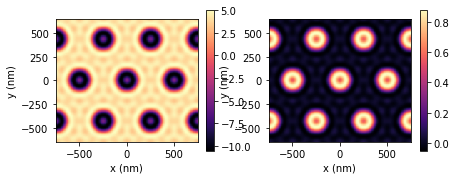

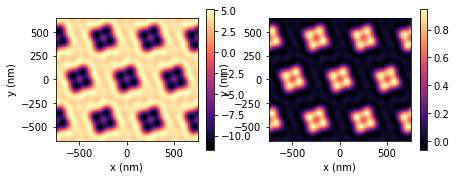

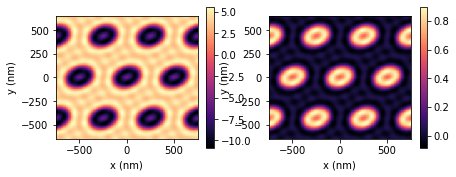

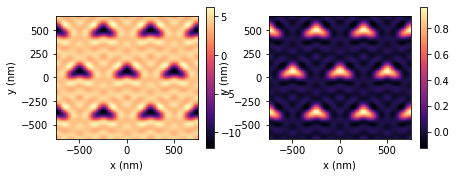

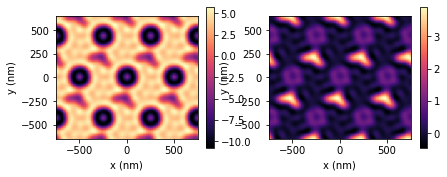

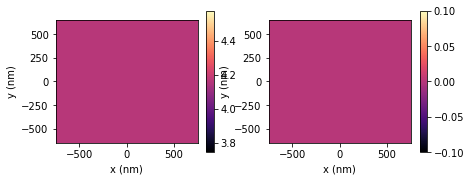

In [4]:
GaAs_absorption = np.zeros((len(grating_list), len(wavelengths)))
grating_absorption = np.zeros((len(grating_list), len(wavelengths)))

for i1, geometry in enumerate(grating_list):
    solar_cell = SolarCell([Layer(material=InGaP_e_barrier, width=si('19nm')),
                                Layer(material=GaAs_pn_junction, width=si('85nm')),
                                Layer(material=InAlP_hole_barrier, width=si('19nm')),
                            Layer(material=SiN, width=si('100nm'), geometry=geometry)])

    S4_setup = rcwa_structure(solar_cell, size=size, options=options,
                              incidence=Air, transmission=Ag)
    RAT = S4_setup.calculate(options)
    GaAs_absorption[i1] = RAT['A_per_layer'][:, 1]
    grating_absorption[i1] = RAT['A_per_layer'][:, 3]
    pattern = S4_setup.get_fourier_epsilon(layer_index=4, wavelength=500, options=options)

Now we plot the absorption in the GaAs (solid lines) and in the grating itself (dashed lines) for each grating type, showing the absorption enhancement in the GaAs relevant to the planar case.

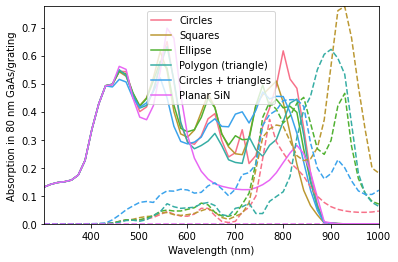

In [5]:
pal = sns.color_palette('husl', len(grating_list))

cols = cycler('color', pal)
plt.rcParams.update({'axes.prop_cycle': cols})

plt.figure()
plt.plot(wavelengths*1e9, GaAs_absorption.T)
plt.legend(['Circles', 'Squares', 'Ellipse',
            'Polygon (triangle)', 'Circles + triangles', 'Planar SiN'])
plt.plot(wavelengths*1e9, grating_absorption.T, '--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorption in 80 nm GaAs/grating')
plt.autoscale(tight=True)
plt.show()